In [63]:
import sys
sys.path.insert(0, "../")
import os
import json
import torch
import librosa.display
import torchvision.transforms as transforms
from dataloaders.image_caption_dataset import ImageCaptionDataset
from davenet_scorer import DaveNetScorer
import matplotlib
import cv2
import skimage.metrics
import numpy as np
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from textwrap import wrap

%matplotlib inline

In [209]:
dataset = "../data/dev_seen_2020.json"
model_dir = "./trained_models"
davenet_path = os.path.join(model_dir, "davenet_vgg16_MISA_1024_pretrained/")
audio_model = os.path.join(davenet_path, "audio_model.pth")
image_model = os.path.join(davenet_path, "image_model.pth")
window_size = 7
smoothing = "max"
mass_p = 0.3
sample_rate = 16000
device = "cuda" if torch.cuda.is_available() else "cpu"
outdir = "../scores"

In [17]:
if not os.path.isdir(outdir):
    os.makedirs(outdir)

In [18]:
smoothing_fn = {"max": np.max, "mean": np.mean}.get(smoothing, np.max)

In [213]:
# Load DaveNet
dave_scorer = DaveNetScorer(audio_model, image_model)

# Dataset
audio_conf = {"use_raw_length": True}
vdataset = ImageCaptionDataset(dataset, audio_conf=audio_conf, image_conf={"center_crop": True}, normalize=False)
vdataset.audio_base_path = os.path.join("../", vdataset.audio_base_path)
vdataset.image_base_path = os.path.join("../", vdataset.image_base_path)
data_key = {x["wav"]:x for x in vdataset.data}
loader = torch.utils.data.DataLoader(vdataset, shuffle=True, num_workers=8, batch_size=1)

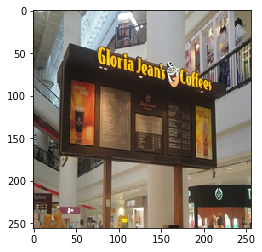

In [222]:
index = np.random.randint(10)
for i, (img, audio, p, wavpath) in enumerate(loader):
    if i == index:
        break

    l = data_key[wavpath[0][wavpath[0].find("wavs"):]]
    uid = l["uttid"]
    asr_text = l["asr_text"]
    
#     if uid != "A2WQT33K6LD9Z5-GSUN_3B1FB5BDCB2390BFB13047C583E9F82A":
#         continue
    
    wav, _ = librosa.load(wavpath[0], sample_rate)
    
    heatmap, _, _, _, _ = dave_scorer.score(audio.squeeze(0), img.squeeze(0))
    N_t, N_r, N_c = heatmap.shape
    
    temporal_heatmap = heatmap.reshape((N_t, N_r * N_c))
    smoothed_heatmap = np.zeros(temporal_heatmap.shape)
    
    for i in range(0, N_t - window_size):
        smoothed_heatmap[i, :] = np.max(temporal_heatmap[i: i + window_size, :], axis = 0)
    
    # Normalize Matches
    total_mass = np.sum(smoothed_heatmap)
    matchmap = smoothed_heatmap / total_mass
    
    # Sort cells
#     N = N_t * N_r * N_c
#     matchmap = matchmap.reshape(N)
#     sorted_cells = np.argsort(matchmap)
    
#     # Retain only cells accounting for mass_p percent of the total density in the image
#     mass_thresh = mass_p * np.sum(matchmap)
#     sum_mass = 0.0
#     for i in range(N - 1, -1, -1):
#         idx = sorted_cells[i]
#         if (matchmap[idx] + sum_mass) <= mass_thresh:
#             sum_mass += matchmap[idx]
#         else:
#             matchmap[idx] = 0.0
    
    matchmap = np.where(smoothed_heatmap >= 0.6, 0.0, 1.0)
    matchmap = smoothed_heatmap
    matchmap[matchmap < 0.2] = 0
    matchmap = matchmap.reshape((N_t, N_r, N_c))
    img_t = img.squeeze(0).permute(1, 2, 0).numpy()
    wav_duration = librosa.get_duration(wav, sr=sample_rate)
    time_step = wav_duration / (N_t)
    max_val = np.max(matchmap)
    
    # Play Audio While Plotting
    # play_audio(wav, args.sample_rate, 4, wait=False)
    
    # Animate plot
    
    prev_heatmap = matchmap[0, :, :]
    heatmaps = []
    audio_segments = []
    stop_audio = []
    insegment = False
    for i in range(window_size, N_t):
        if skimage.metrics.structural_similarity(matchmap[i, :, :], prev_heatmap, full=True)[0] < 0.4:
            # Filter to matchmap at this time step
            if matchmap[i, :, :].sum() < 40:
                if insegment:
                    stop_audio.append(i * time_step)
                insegment = False
                continue
            if insegment:
                stop_audio.append(i * time_step)
                insegment = False
            insegment = True
            full_matchmap = np.array(Image.fromarray(matchmap[i, :, :]).resize((img_t.shape[0], img_t.shape[1])))
            heatmaps.append(full_matchmap)
            audio_segments.append(i * time_step)
            prev_heatmap = matchmap[i, :, :]
        
        # Trying to remove vmin and vmax helps make it clearer to see changes through time.
#         ax[0].imshow(full_matchmap, vmin=0.0, vmax=max_val, cmap="hot", alpha=0.4)
#         ax[0].join(ax[0], ax[1])

#         ax[1].axvline(i * time_step, linewidth=2, color='k', linestyle='dashed')
#         plt.show()
#         plt.savefig(args.outdir + "/%s_%d.jpg" % (uid, i))
#         plt.close()
    if i == index:
        break
plt.imshow(img_t)

In [223]:
cmap = matplotlib.cm.get_cmap("tab10")

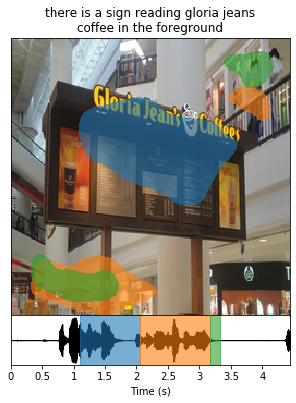

In [241]:
f, ax = plt.subplots(2, 1, figsize = (5, 8), gridspec_kw={'height_ratios': [2, 0.2]})
f.subplots_adjust(hspace=-0.4, wspace=0)
title = "\n".join(wrap(asr_text, 40))
librosa.display.waveplot(wav, sr=sample_rate, color="k", ax=ax[1])

ax[0].set_title(title)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_xlabel("Time (s)")

ax[0].imshow(img_t)

overlay_alpha = 0.6

for i, h in enumerate(heatmaps):
    h_scaled = (h - h.min())/(h.max() - h.min())
    h_scaled = (h_scaled > 0.5).astype(float)
    c = np.array(cmap.colors[i % len(cmap.colors)])
    h_rgb = h_scaled[:, :, None] * c[None, :]
    ax[0].imshow(np.dstack([h_rgb, h_scaled[:, :, None] * overlay_alpha]))
    if i != len(heatmaps):
        ax[1].axvspan(audio_segments[i], stop_audio[i], alpha=overlay_alpha, color=c)